## [GITHUB](https://github.com/saugatshakya/cnn_predicting_cat_dog)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#2.  Load the images using built-in PyTorch datasets.ImageFolder.
train_dir = 'data/train'
train_data = datasets.ImageFolder(root=train_dir, transform=transforms.Compose([
transforms.RandomRotation(10), # rotate +/- 10 degrees
transforms.RandomHorizontalFlip(), # reverse 50% of images
transforms.Resize(224), # resize shortest side to 224 pixels
transforms.CenterCrop(224), # crop longest side to 224 pixels at center
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406],
[0.229, 0.224, 0.225])
]))


In [3]:
#2.  Load the images using built-in PyTorch datasets.ImageFolder.
test_dir = 'data/test'
test_data = datasets.ImageFolder(root=test_dir, transform=transforms.Compose([
transforms.Resize(224),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406],
[0.229, 0.224, 0.225])
]))


In [4]:
train_data

Dataset ImageFolder
    Number of datapoints: 18002
    Root location: data/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
test_data

Dataset ImageFolder
    Number of datapoints: 6998
    Root location: data/test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

In [7]:
class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['cat', 'dog']
Training images available: 18002
Testing images available:  6998


Label: [1 1 1 1 1 1 0 1 0 0]
Class: dog dog dog dog dog dog cat dog cat cat


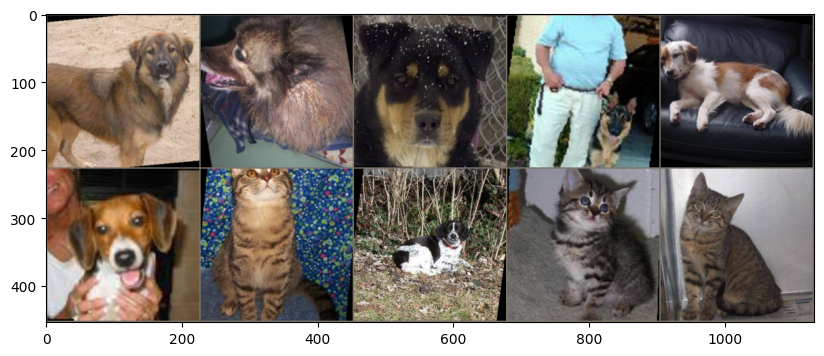

In [8]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [9]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

In [10]:
fake_input = torch.randn(1, 3, 224, 224, dtype=torch.float32)
conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1)
o = conv1(fake_input)
print(o.shape)

torch.Size([1, 6, 222, 222])


In [11]:
maxpool1 = F.max_pool2d(o, 2, 2)
print(maxpool1.shape)

torch.Size([1, 6, 111, 111])


In [12]:
conv2 = nn.Conv2d(6, 16, 3, 1)
o = conv2(maxpool1)
print(o.shape)

torch.Size([1, 16, 109, 109])


In [13]:
maxpool2 = F.max_pool2d(o, 2, 2)
print(maxpool2.shape)

torch.Size([1, 16, 54, 54])


In [14]:
CNNmodel  = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [15]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [16]:
count_parameters(CNNmodel)

     162
       6
     864
      16
 5598720
     120
   10080
      84
     168
       2
________
 5610222


In [17]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.66211760  accuracy:  57.450%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.59258384  accuracy:  60.125%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.92734563  accuracy:  61.533%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.81686163  accuracy:  63.112%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.45065776  accuracy:  68.450%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.79987067  accuracy:  69.675%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.31779030  accuracy:  70.417%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.73145205  accuracy:  70.763%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.57339489  accuracy:  73.250%
epoch:  2  batch:  400 [  4000/8000]  loss: 0.47094315  accuracy:  73.175%
epoch:  2  batch:  600 [  6000/8000]  loss: 0.47011685  accuracy:  73.517%
epoch:  2  batch:  800 [  8000/8000]  loss: 0.28765473  accuracy:  73.963%

Duration: 258 seconds


In [18]:
torch.save(CNNmodel.state_dict(), 'models/CustomImageCNNModel.pt')

In [19]:
train_losses = [loss.item() for loss in train_losses]
test_losses  = [loss.item() for loss in test_losses]

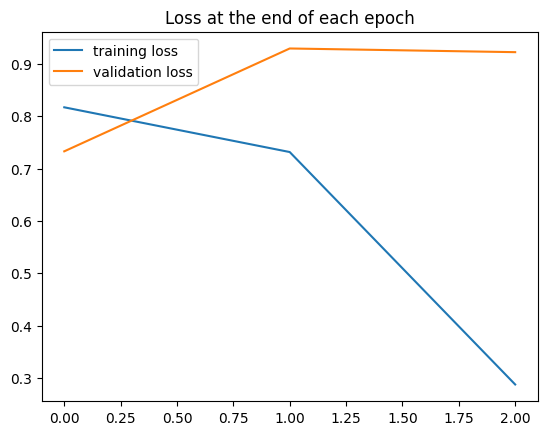

In [20]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

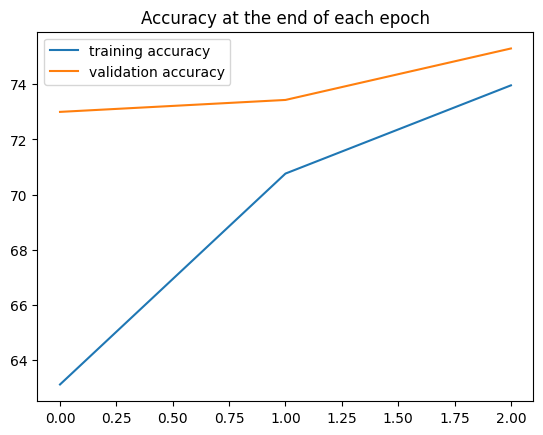

In [21]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [22]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2190), tensor(2203), tensor(2259)]
Test accuracy: 75.300%


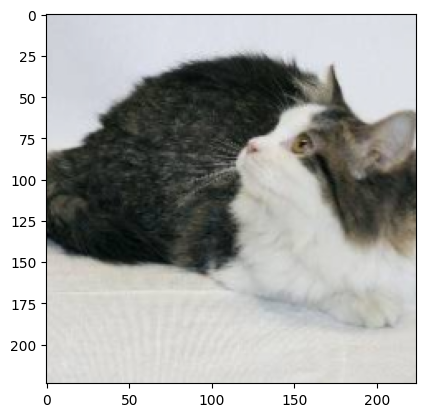

In [23]:
x = 2019
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [24]:
test_data[x][0].shape

torch.Size([3, 224, 224])

In [25]:
# CNN Model Prediction:

CNNmodel.eval()
with torch.no_grad():
    new_pred = CNNmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 cat


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Set model to evaluation mode
CNNmodel.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        y_val = CNNmodel(X_test)
        preds = torch.argmax(y_val, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())

# Compute metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"\nModel Performance on Test Data:")
print(f"Accuracy : {acc*100:.2f}%")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# Detailed class-wise report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))



Model Performance on Test Data:
Accuracy : 74.88%
Precision: 0.7560
Recall   : 0.7488
F1-score : 0.7470

Classification Report:
              precision    recall  f1-score   support

         cat       0.80      0.67      0.73      3499
         dog       0.71      0.83      0.77      3499

    accuracy                           0.75      6998
   macro avg       0.76      0.75      0.75      6998
weighted avg       0.76      0.75      0.75      6998



Total Misclassified Samples: 1758


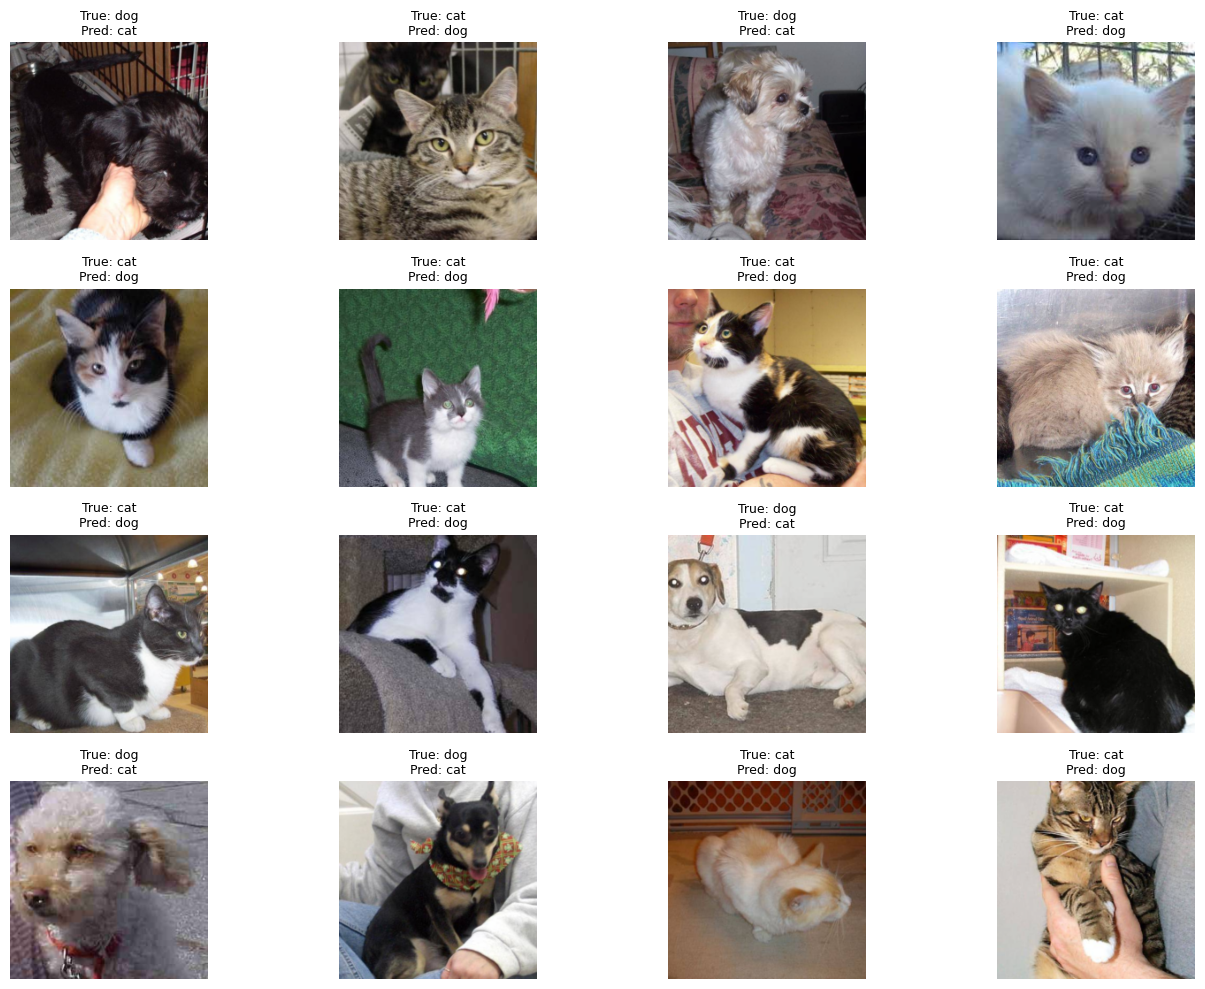

In [27]:
# Ensure model is in eval mode
CNNmodel.eval()

misclassified_images = []
misclassified_labels = []
misclassified_preds = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        y_val = CNNmodel(X_test)
        preds = torch.argmax(y_val, dim=1)
        for i in range(len(y_test)):
            if preds[i] != y_test[i]:
                misclassified_images.append(X_test[i])
                misclassified_labels.append(y_test[i])
                misclassified_preds.append(preds[i])

# Number of misclassified samples
print(f"Total Misclassified Samples: {len(misclassified_images)}")

# Show 16 misclassified images
n_show = min(16, len(misclassified_images))
plt.figure(figsize=(14, 10))
for i in range(n_show):
    img = misclassified_images[i]
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                  np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[misclassified_labels[i]]}\nPred: {class_names[misclassified_preds[i]]}", fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()



### 🧠 **Error Analysis Observation**

After examining multiple sets of misclassified images, several consistent patterns emerged:

1. **Type of Misclassification**
   The model frequently misclassifies **dogs as cats** and **cats as dogs**, showing that it struggles to learn robust class-specific features distinguishing the two. The total number of misclassified samples (1,794) indicates that a significant portion of the model’s predictions are incorrect.

2. **Visual Ambiguity in Data**
   Many of the misclassified images contain:

   * **Partially cropped faces or bodies** (only part of the animal is visible).
   * **Low lighting or motion blur**, which reduces clear edge and texture information.
   * **Similar fur colors and textures** (e.g., light brown or white tones that appear in both classes).
   * **Cluttered or indoor backgrounds** that make it difficult for the model to isolate the animal from its surroundings.
   * **Non-standard viewpoints** or **poses**, where the animal’s defining features (e.g., ears, snout, whiskers) are not visible.

3. **Model Behavior**

   * The CNN likely focuses on **texture and color cues** rather than true shape or structural patterns.
   * Its limited depth and receptive field restrict its ability to capture **global context** (e.g., head shape, body structure).
   * The network appears to overfit on certain visual cues found more often in one class (e.g., cats photographed indoors, dogs outdoors).

---

### 🧩 **Summary**

> The misclassified samples reveal that the model struggles primarily with images that have low visual clarity, ambiguous textures, or limited context. The CNN appears to rely heavily on color and local texture rather than shape, leading to confusion between cats and dogs in challenging conditions. Enhancing data diversity and leveraging a deeper pretrained network are likely to improve generalization and reduce such errors.


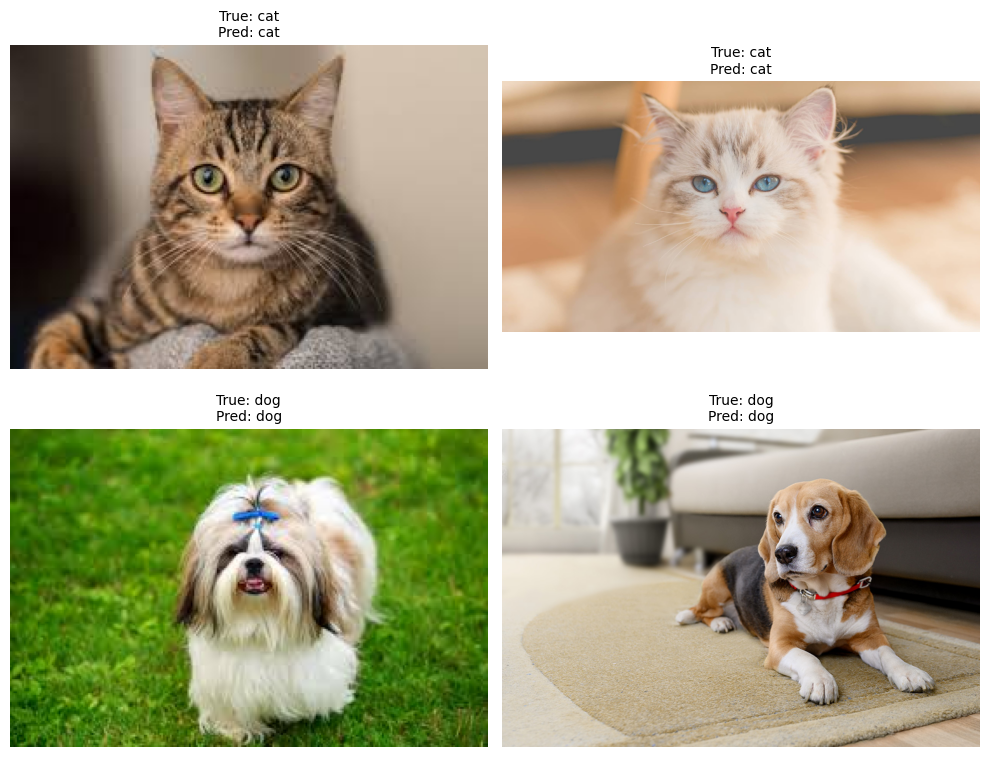

In [28]:
import requests
from io import BytesIO
from PIL import Image

# Reload trained model for inference
inference_model = ConvolutionalNetwork()
inference_model.load_state_dict(torch.load("models/CustomImageCNNModel.pt", map_location=torch.device("cpu")))
inference_model.eval()

# Define class names (must match training)
class_names = ['cat', 'dog']

# Sample internet images (2 cats, 2 dogs)
urls = [
    ("cat", "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSbvCFFFCsQYbI82fOx2Tv9GHGxS2DQa34geg&s"),
    ("cat", "https://www.diamondpet.com/wp-content/uploads/2022/02/close-up-white-cat-with-blue-eyes-121224.jpg"),
    ("dog", "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSUd4oSev3-H-OEKifmV2wqiDg0L39Sscq5UA&s"),
    ("dog", "https://d3544la1u8djza.cloudfront.net/APHI/Blog/2023/September/small-breeds-hero.jpg")
]

# Preprocessing (same as training)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

plt.figure(figsize=(10, 8))

for i, (true_label, url) in enumerate(urls):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content)).convert("RGB")

        input_tensor = transform(img).unsqueeze(0)

        # Inference
        with torch.no_grad():
            output = inference_model(input_tensor)
            _, pred = torch.max(output, 1)
            pred_label = class_names[pred.item()]

        # Display result
        plt.subplot(2, 2, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
        plt.axis('off')

    except Exception as e:
        print(f"Error loading {url}: {e}")

plt.tight_layout()
plt.show()


### 🧠 **Inference Observation**

> The model was tested using four unseen internet images (two cats and two dogs), and it correctly classified all of them. This indicates that the CNN has successfully learned to extract distinguishing visual features between cats and dogs that generalize beyond the training dataset.
>
> The correct predictions on real-world images with different lighting, poses, and backgrounds suggest that the network’s learned filters capture essential visual cues rather than memorizing training samples.
>
> However, since this model is relatively shallow compared to modern architectures, its robustness may still be limited when faced with more complex, occluded, or low-quality images.
>
> **In summary:**
>
> * ✅ All predictions were correct, showing strong generalization for simple real-world inputs.
> * 🧩 The network likely focuses on clear texture and color differences.
> * 🚀 Using a deeper pretrained model (e.g., ResNet18 or VGG16) and larger, more diverse data could further enhance performance and stability.



## 10

In [29]:
train_dir = 'data/train'
train_data = datasets.ImageFolder(root=train_dir, transform=transforms.Compose([
transforms.Resize(224), # resize shortest side to 224 pixels
transforms.CenterCrop(224), # crop longest side to 224 pixels at center
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406],
[0.229, 0.224, 0.225])
]))


In [30]:
test_dir = 'data/test'
test_data = datasets.ImageFolder(root=test_dir, transform=transforms.Compose([
transforms.Resize(224),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406],
[0.229, 0.224, 0.225])
]))


In [31]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

In [34]:
CNNmodel  = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [35]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.47412235  accuracy:  58.500%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.55916631  accuracy:  60.700%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.64848030  accuracy:  62.450%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.55596799  accuracy:  63.913%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.60589343  accuracy:  72.250%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.31461558  accuracy:  73.500%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.46818623  accuracy:  73.667%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.49872786  accuracy:  74.037%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.42848140  accuracy:  82.500%
epoch:  2  batch:  400 [  4000/8000]  loss: 0.27022400  accuracy:  82.175%
epoch:  2  batch:  600 [  6000/8000]  loss: 0.81372833  accuracy:  81.567%
epoch:  2  batch:  800 [  8000/8000]  loss: 0.61619788  accuracy:  81.350%

Duration: 212 seconds


In [36]:
train_losses = [loss.item() for loss in train_losses]
test_losses  = [loss.item() for loss in test_losses]

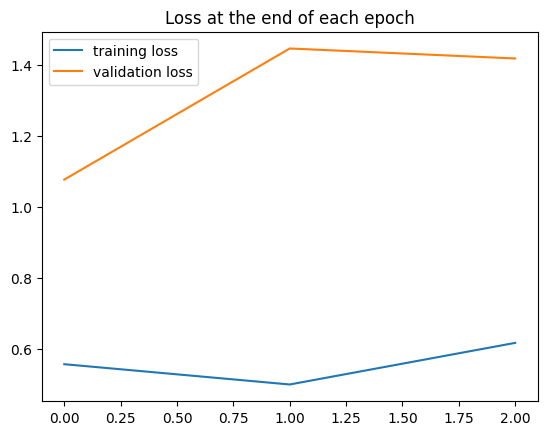

In [37]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

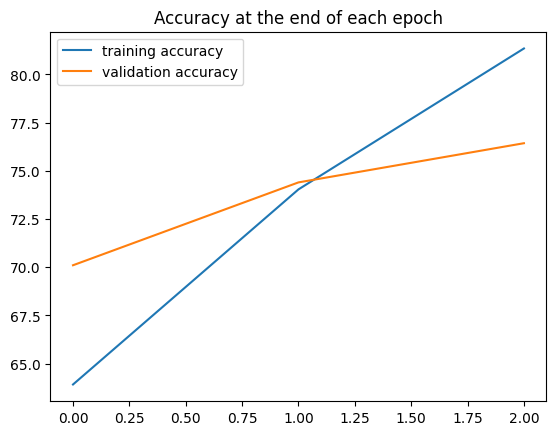

In [38]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [39]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2103), tensor(2232), tensor(2293)]
Test accuracy: 76.433%


### **Observation**

1. **With Online Augmentation (Rotation + Flip)**

* Test accuracy: `75.3%`
* Slightly lower training accuracy compared to no augmentation, indicating that the model is **working harder to generalize** on augmented data.
* Test accuracy is slightly lower, suggesting that for this particular dataset, simple augmentations introduced minor variations that the model struggled with, or the dataset is already fairly consistent.

2. **Without Augmentation**

* Test accuracy: `76.4%`
* Higher test accuracy despite no augmentation, showing that the model **fits the dataset distribution more directly**.
* This can happen if the dataset is already well-aligned and doesn’t require extra variability to generalize.

---

### **Conclusion**

> In this case, online augmentation (rotation + horizontal flip) slightly reduced test accuracy, likely because the dataset is clean and consistent. Augmentation increases model robustness in general, but its benefit depends on dataset variability. For more complex or diverse data, augmentation would usually improve generalization.
